## 🧠 Modelagem Supervisionada

Nesta etapa, foi implementada uma abordagem supervisionada em duas fases:  
(1) **Classificação binária** para detecção da ocorrência de falha  
(2) **Classificação multiclasse** para identificação do tipo de falha.

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PowerTransformer, OrdinalEncoder, label_binarize
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN

from src.config import DADOS_TRATADOS, PASTA_MODELOS

sns.set_theme(palette='bright')
warnings.simplefilter("ignore")
RANDOM_STATE = 42

In [2]:
# Carrega dataset
df = pd.read_csv(DADOS_TRATADOS)

# Filtro para apenas registros com falha
df_failure = df[df['Target'] == 1].copy()

# Codificação de labels para multiclasses
le = LabelEncoder()
df_failure['Failure Type'] = le.fit_transform(df_failure['Failure Type'])

# Separação binária e multiclasses
X_bin = df.drop(columns=['Target', 'Failure Type'])
y_bin = df['Target']

X_multi = df_failure.drop(columns=['Target', 'Failure Type'])
y_multi = df_failure['Failure Type']

# Split dos conjuntos
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bin, y_bin, test_size=0.2, stratify=y_bin, random_state=RANDOM_STATE)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(X_multi, y_multi, test_size=0.2, stratify=y_multi, random_state=RANDOM_STATE)

# Colunas numéricas e categóricas
num_cols = X_bin.select_dtypes(include=['number']).columns
cat_cols = X_bin.select_dtypes(include=['object']).columns

### 🔧 Pré-processamento dos Dados

Para garantir consistência e robustez no treinamento, foi construído um pipeline de pré-processamento com as seguintes etapas:

- Imputação de valores ausentes:
  - **Numéricas**: média (`SimpleImputer`)
  - **Categóricas**: moda (`SimpleImputer`)
- Transformação de variáveis:
  - **Numéricas**: `PowerTransformer` (normalização gaussiana)
  - **Categóricas**: codificação ordinal (`OrdinalEncoder`)
- Balanceamento com **SMOTEENN**: combinação de oversampling (SMOTE) e undersampling (ENN) para lidar com o forte desbalanceamento do dataset.

In [3]:
# Pré-processamento
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', PowerTransformer())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [4]:
# Pipeline com balanceamento
def build_pipeline(model):
    return ImbPipeline([
        ('prep', preprocessor),
        ('resample', SMOTEENN(random_state=RANDOM_STATE)),
        ('clf', model)
    ])

# Modelos
modelos = {
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
    'NaiveBayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}

# Parâmetros
param_grids = {
    'RandomForest': {
        'clf__class_weight': ['balanced', 'balanced_subsample', None],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20]
    },
    'LogisticRegression': {
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.1, 1, 10]
    },
    'NaiveBayes': {
        'clf__var_smoothing': [1e-10, 1e-9]
    },
    'KNN': {
        'clf__n_neighbors': [3, 5],
        'clf__weights': ['uniform', 'distance']
    }
}

### 🔍 Classificação Binária (Falha vs. Não Falha)

#### ✅ Estratégia:

- Modelos avaliados: `RandomForest`, `LogisticRegression`, `NaiveBayes`, `KNN`
- Validação: **5-fold cross-validation** estratificada
- Otimização com `GridSearchCV`, usando **`recall_weighted`** como métrica principal pois foi considerado que, para a indústria, o custo de uma falha não percebida é maior que de uma parada desnecessária
#### 📈 Resultados:

O modelo com melhor desempenho foi o **RandomForest**, com as seguintes métricas:

- **F1-Score ponderado**: 0.96
- **Recall ponderado**: 0.98
- **Precisão**: 0,97
- **AUC-ROC**: 0.9682
- **Importância das variáveis**: `Rotational Speed`, `Process Temperature` e `Torque` foram as mais relevantes.

#### 📊 Visualizações:

- **Matriz de Confusão:** mostra uma excelente taxa de acerto na classe negativa (sem falha), e recall moderado na classe positiva.
- **Curva ROC:** área sob a curva próxima de 1, indicando alta discriminatividade.
- **Curva Precision-Recall:** utilizada para analisar o trade-off entre sensibilidade e precisão em cenários desbalanceados.


In [5]:
# Grid Search para modelo binário focado em recall
best_models_bin = {}

for nome, modelo in modelos.items():
    grid_bin = GridSearchCV(
        estimator=build_pipeline(modelo),
        param_grid=param_grids[nome],
        cv=kf,
        scoring='recall_weighted'
    )
    grid_bin.fit(Xb_train, yb_train)
    best_models_bin[nome] = grid_bin.best_estimator_
    print(f"\nMelhores parâmetros para {nome}: {grid_bin.best_params_}")


Melhores parâmetros para RandomForest: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__n_estimators': 100}

Melhores parâmetros para LogisticRegression: {'clf__C': 1, 'clf__penalty': 'l1'}

Melhores parâmetros para NaiveBayes: {'clf__var_smoothing': 1e-10}

Melhores parâmetros para KNN: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}


In [6]:
# Avaliação binária
print("\n=== Classificação Binária (Falha vs Não Falha) ===")
for nome, modelo in best_models_bin.items():
    y_pred = modelo.predict(Xb_test)
    print(f"\nModelo: {nome}")
    print(classification_report(yb_test, y_pred, target_names=['0', '1']))


=== Classificação Binária (Falha vs Não Falha) ===

Modelo: RandomForest
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1932
           1       0.40      0.82      0.54        68

    accuracy                           0.95      2000
   macro avg       0.70      0.89      0.76      2000
weighted avg       0.97      0.95      0.96      2000


Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1932
           1       0.08      0.81      0.15        68

    accuracy                           0.68      2000
   macro avg       0.54      0.74      0.48      2000
weighted avg       0.96      0.68      0.78      2000


Modelo: NaiveBayes
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1932
           1       0.14      0.84      0.23        68

    accuracy                           0.81      2000
   mac

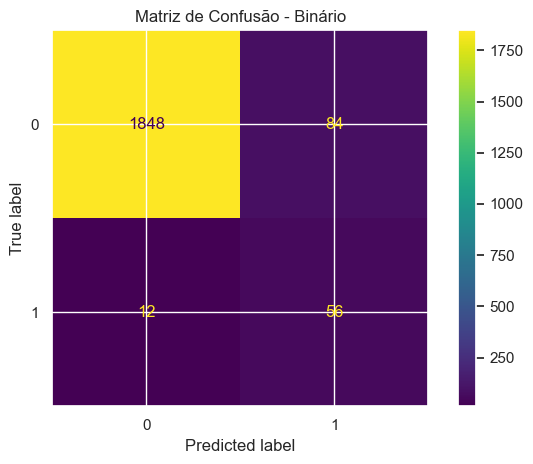

In [7]:
# Seleção do melhor modelo
yb_pred = best_models_bin['RandomForest'].predict(Xb_test)
yb_proba = best_models_bin['RandomForest'].predict_proba(Xb_test)[:, 1]

pipe_rf_bin = best_models_bin['RandomForest']

ConfusionMatrixDisplay.from_estimator(pipe_rf_bin, Xb_test, yb_test)
plt.title("Matriz de Confusão - Binário")
plt.tight_layout()
plt.show()

AUC-ROC: 0.9682


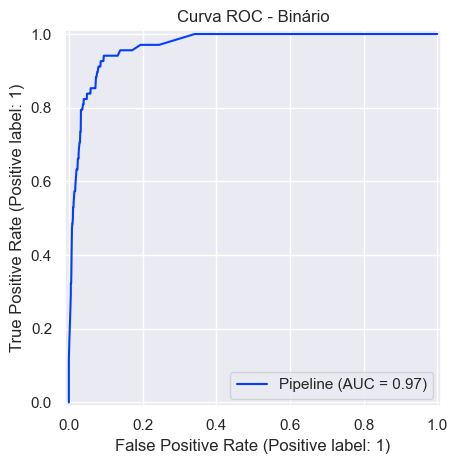

In [8]:
roc_auc = roc_auc_score(yb_test, yb_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(pipe_rf_bin, Xb_test, yb_test)
plt.title("Curva ROC - Binário")
plt.tight_layout()
plt.show()

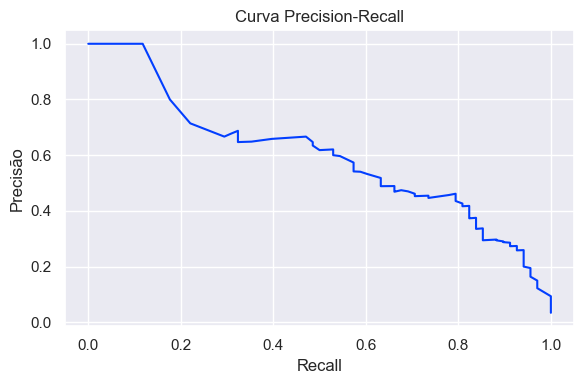

In [9]:
# Curva Precision-Recall
prec, rec, _ = precision_recall_curve(yb_test, yb_proba)
plt.figure(figsize=(6, 4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.tight_layout()
plt.show()

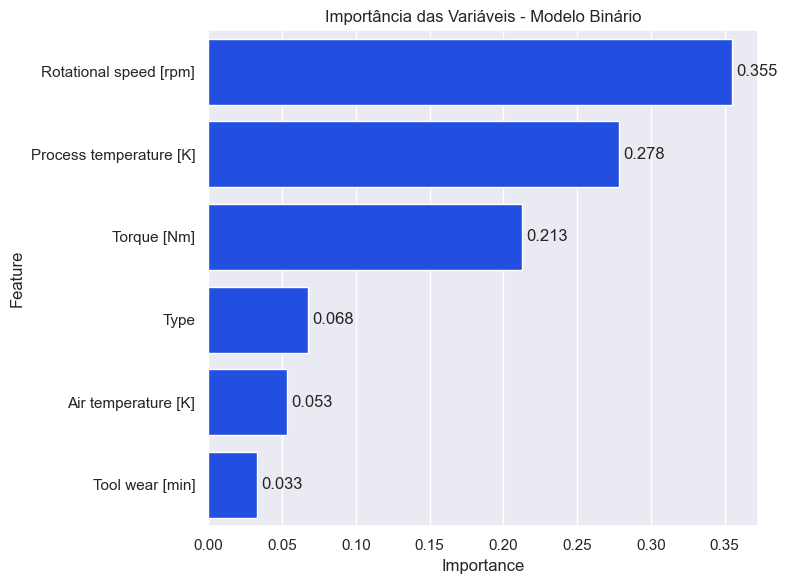

In [10]:
# Importância das features - RandomForest (binário)
importances = pipe_rf_bin.named_steps['clf'].feature_importances_
features = Xb_train.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feat_df)

# Adiciona os rótulos diretamente nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)
    
plt.title('Importância das Variáveis - Modelo Binário')
plt.tight_layout()
plt.show()

### 🔎 Classificação Multiclasse (Tipo de Falha)

#### ✅ Estratégia:

- Treinamento somente sobre registros com falha (`Target = 1`)
- Modelos e validação idênticos à etapa binária
- Otimização via `f1_weighted` para garantir performance geral em múltiplas classes

#### 📈 Resultados:

O modelo **RandomForest** também se destacou nesta etapa, com desempenho consistente entre as classes. As métricas `precision`, `recall` e `f1-score` foram extraídas por classe com o `classification_report`.

#### 📊 Visualizações:

- **Curvas ROC One-vs-Rest:** foi implementada uma abordagem por classe, utilizando `label_binarize`, resultando em:
  - AUC por tipo de falha
  - Comparação entre sensibilidade (TPR) e especificidade (FPR) de cada classe

In [11]:
# Treinamento multiclasses com GridSearch e SMOTEENN
best_models_multi = {}

for nome, modelo in modelos.items():
    grid = GridSearchCV(
        estimator=build_pipeline(modelo),
        param_grid=param_grids[nome],
        cv=kf,
        scoring='f1_weighted'
    )
    grid.fit(Xm_train, ym_train)
    best_models_multi[nome] = grid.best_estimator_
    print(f"\nMelhores parâmetros para {nome}: {grid.best_params_}")


Melhores parâmetros para RandomForest: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__n_estimators': 100}

Melhores parâmetros para LogisticRegression: {'clf__C': 0.1, 'clf__penalty': 'l1'}

Melhores parâmetros para NaiveBayes: {'clf__var_smoothing': 1e-10}

Melhores parâmetros para KNN: {'clf__n_neighbors': 3, 'clf__weights': 'uniform'}


In [12]:
# Avaliação multiclasses
print("\n=== Classificação Multiclasses (Tipo de Falha) ===")
for nome, modelo in best_models_multi.items():
    y_pred = modelo.predict(Xm_test)
    print(f"\nModelo: {nome}")
    print(classification_report(ym_test, y_pred, target_names=le.classes_))


=== Classificação Multiclasses (Tipo de Falha) ===

Modelo: RandomForest
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.92      1.00      0.96        22
              No Failure       0.67      1.00      0.80         2
      Overstrain Failure       0.86      0.75      0.80        16
           Power Failure       0.89      0.84      0.86        19
       Tool Wear Failure       0.89      0.89      0.89         9

                accuracy                           0.88        68
               macro avg       0.84      0.90      0.86        68
            weighted avg       0.88      0.88      0.88        68


Modelo: LogisticRegression
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.78      0.95      0.86        22
              No Failure       0.00      0.00      0.00         2
      Overstrain Failure       0.68      0.94      0.79        16
           Power Failure       0.67 

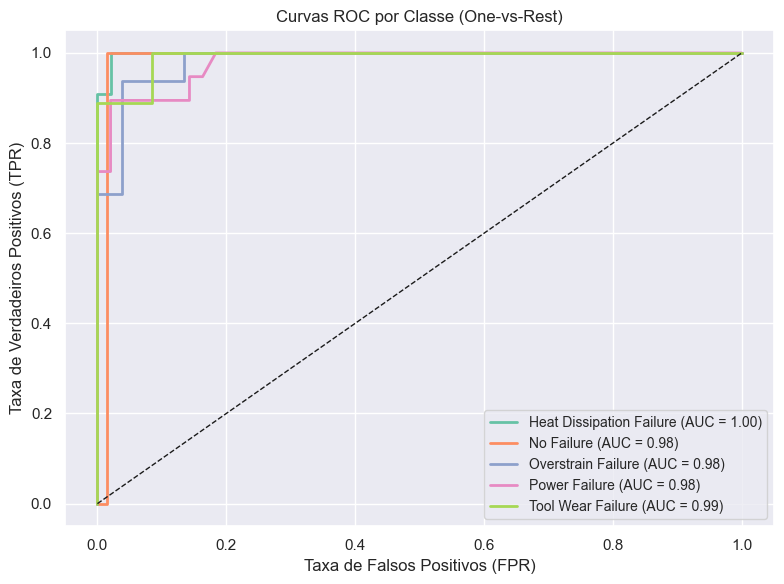

In [13]:
# Seleção do melhor modelo multiclasse
pipe_rf_multi = best_models_multi['RandomForest']

# Binariza os labels (ex: classe 0 vira [1, 0, 0, 0, 0])
ym_test_bin = label_binarize(ym_test, classes=range(len(le.classes_)))
ym_proba = pipe_rf_multi.predict_proba(Xm_test)
n_classes = ym_proba.shape[1]

# Curvas ROC por classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ym_test_bin[:, i], ym_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = sns.color_palette("Set2", n_classes)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curvas ROC por Classe (One-vs-Rest)")
plt.legend(loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

### 💾 Salvamento dos Modelos

Os modelos finais foram salvos com persistência usando `joblib`, facilitando reuso e implantação futura:

- `modelo_rf_binario.pkl`
- `modelo_rf_multiclasse.pkl`


In [14]:
# Salvando modelo binário
joblib.dump(pipe_rf_bin, PASTA_MODELOS / 'modelo_rf_binario.pkl')

# Salvando modelo multiclasse
joblib.dump(pipe_rf_multi, PASTA_MODELOS / 'modelo_rf_multiclasse.pkl')

['C:\\Users\\fcode\\OneDrive\\Documentos\\_Projetos\\predictive-maintanence\\models\\modelo_rf_multiclasse.pkl']